In [154]:
import pandas as pd
import numpy as np
import unidecode
import json
import string
from time import time
import re

%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from urlextract import URLExtract
from collections import defaultdict, Counter

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.utils.extmath import density
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wardhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading files into dataframes

In [2]:
us_videos = pd.read_csv('./USvideos.csv')
ca_videos = pd.read_csv('./CAvideos.csv')
gb_videos = pd.read_csv('./GBvideos.csv')

In [3]:
us_videos.shape

(40949, 16)

In [4]:
ca_videos.shape

(40881, 16)

In [5]:
gb_videos.shape

(38916, 16)

In [8]:
combined_videos = us_videos.append(ca_videos, ignore_index=True).append(gb_videos, ignore_index=True)

In [146]:
combined_videos.shape

(120746, 16)

Load the json categories into a python dictionary

In [10]:
def load_categories(fn):
    cat_str = "" # the json string

    with open(fn, 'r') as f:
        cat_str = f.read()
    
    # python dictionary
    cat_obj = json.loads(cat_str)

    # array of dictionaries
    cats_arr = cat_obj['items']

    # dataframe
    df = pd.json_normalize(cats_arr).convert_dtypes()

    # convert id to int
    df['id'] = pd.to_numeric(df['id'])

    # select just id and title
    df = df.loc[:,['id', 'snippet.title']]

    return df

In [11]:
us_cats = load_categories('./US_category_id.json')
ca_cats = load_categories('./CA_category_id.json')
gb_cats = load_categories('./GB_category_id.json')

In [12]:
ca_cats.shape

(31, 2)

In [13]:
gb_cats.shape

(31, 2)

Extra category in us categories, but the rest of the categories are the same

In [14]:
us_cats.shape

(32, 2)

## Select columns from us_videos

We select the columns with identifying information, classification, and text descriptions

In [27]:
df = combined_videos.loc[:,['title', 'channel_title', 'category_id', 'tags', 'description']].convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120746 entries, 0 to 120745
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   title          120746 non-null  string
 1   channel_title  120746 non-null  string
 2   category_id    120746 non-null  Int64 
 3   tags           120746 non-null  string
 4   description    118268 non-null  string
dtypes: Int64(1), string(4)
memory usage: 4.7 MB


In [28]:
dfd = df.drop_duplicates(subset=['title', 'channel_title'], ignore_index=True)

print(dfd.count(), "\n")

# merge on category_id
dfd = dfd.merge(us_cats, left_on='category_id', right_on='id')

# drop category_id
dfd = dfd.drop(['id', 'category_id'], axis=1)
dfd = dfd.rename(columns={"snippet.title": "category"})
dfd.head(1)

title            30713
channel_title    30713
category_id      30713
tags             30713
description      29622
dtype: int64 



,title,channel_title,tags,description,category
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,SHANtell martin,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs


## Text Preprocessing

Things to consider removing:
- emails: `c.amber@gmail.com`
- normal urls: `http://facebook.com`
- other urls: `www.facebook.com`
- unicode: `\xa0`
- punctuation: `!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
- numbers: `1234`
- nonsense: `PLvahqwMqN4M35d1XdbUEWZT_r36Z6tIz3`

In [29]:
en_stops = set([word.replace("'", '') for word in stopwords.words('english')])

# custom stop_words
custom_stops = set(["cant", "follow", "subscribe", "like", "comment"])

# terms to ignore
ignore = en_stops | custom_stops

# special characters to remove
specials = r'[' + re.escape(string.punctuation) + ']'

porter_stemmer = PorterStemmer()

In [30]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Cleaning the title?

In [31]:
def clean_title(s, stemming=True, min_length=0):
    
    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(s, errors='ignore')
    
    # replace dashes with empty space
    ss = ss.replace('-', ' ')

    ss = re.sub(specials, '', ss)
    
    words = ss.split(' ')
    
    words = [word.lower().strip() for word in words if len(word) > min_length and word not in ignore]
    
    if stemming:
        words = map(porter_stemmer.stem, words)
    
    return ' '.join(words)

In [32]:
%%time
titles = dfd['title']
ctitles = titles.apply(clean_title, stemming=False)
ctitles_stem = titles.apply(clean_title, stemming=True)

CPU times: user 3.81 s, sys: 9.42 ms, total: 3.81 s
Wall time: 3.83 s


In [33]:
titles[0]

'WE WANT TO TALK ABOUT OUR MARRIAGE'

In [34]:
ctitles[0]

'we want to talk about our marriage'

In [35]:
ctitles_stem[0]

'we want to talk about our marriag'

#### Cleaning the tags

In [36]:
def clean_tags(s, stemming=True, min_length=2):

    ss = s.replace('|', ' ')

    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(ss, errors='ignore')

    # replace dashes with empty space
    ss = ss.replace('-', ' ')

    ss = re.sub(specials, '', ss)

    words = ss.split(' ')

    words = [word.lower().strip() for word in words if len(word) > min_length and word not in ignore]

    if stemming:
        words = map(porter_stemmer.stem, words)

    return ' '.join(words)

In [37]:
%%time
tags = dfd['tags']
ctags = tags.apply(clean_tags, stemming=False)
ctags_stem = tags.apply(clean_tags, stemming=True)

CPU times: user 15.6 s, sys: 18.4 ms, total: 15.6 s
Wall time: 15.6 s


In [38]:
tags[397]

'BuzzFeed|"BuzzFeedBlue"|"BuzzFeed Blue"|"Blue"|"beard"|"bearded men"|"men"|"bearded"|"guys"|"shave"|"clean shaven"|"clean"|"shaven"|"baby faced"|"baby"|"faced"|"try"|"men try"|"we try"|"people try"|"bearded men try going clean shaven"|"clean-shaven"|"bare face"|"bare faced"|"razor"|"shaving"|"grooming"|"health"|"men\'s health"|"facial hair"|"beards"|"mustache"|"manly"'

In [39]:
ctags[397]

'buzzfeed buzzfeedblue buzzfeed blue blue beard bearded men men bearded guys shave clean shaven clean shaven baby faced baby faced try men try try people try bearded men try going clean shaven clean shaven bare face bare faced razor shaving grooming health mens health facial hair beards mustache manly'

In [40]:
ctags_stem[397]

'buzzfe buzzfeedblu buzzfe blue blue beard beard men men beard guy shave clean shaven clean shaven babi face babi face tri men tri tri peopl tri beard men tri go clean shaven clean shaven bare face bare face razor shave groom health men health facial hair beard mustach manli'

#### Cleaning the description

In [41]:
extractor = URLExtract(extract_email=True)

In [42]:
def clean_desc(s, stemming=True, min_length=3):

    # Handle case of missing description
    if pd.isna(s):
        return ''

    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(s, errors='ignore')
    
    # replace newlines and dashes with empty space
    ss = re.sub(r'(' + re.escape("\\n") + ')|-', ' ', ss)

    # find and remove urls
    for url in extractor.find_urls(ss[::]):
        ss = re.sub(r'' + re.escape(url), '', ss)
    
    res = ss.split(' ')
    
    idx = 0
    for word in res[::]:
        # remove punctuation
        cword = re.sub(specials, '', word).strip().lower()
        if len(cword) > min_length and cword not in ignore:
            res[idx] = cword
            idx += 1

    if stemming:
        return ' '.join(map(porter_stemmer.stem, res[:idx]))
    else:
        return ' '.join(res[:idx])

In [44]:
%%time
desc = dfd['description']
cdesc = desc.apply(clean_desc, stemming=False)
cdesc_stem = desc.apply(clean_desc, stemming=True)

CPU times: user 7min 20s, sys: 117 ms, total: 7min 20s
Wall time: 7min 21s


In [45]:
desc[28]
# desc[28] - dash

'Eminem speaks on working with Beyoncé on his Shade 45 interview with DJ Whoo Kid + Lord Sear.\\n\\nShade 45, the uncensored hip-hop channel created by Eminem.'

In [46]:
cdesc[28]

'eminem speaks working beyonce shade interview whoo lord sear shade uncensored channel created eminem'

In [47]:
cdesc_stem[28]

'eminem speak work beyonc shade interview whoo lord sear shade uncensor channel creat eminem'

## Term Frequency

### Combine titles, tags, descriptions...

Let's find a good minimum document frequency

In [48]:
%%time

num_features = []

for min_df in range(1,20):
    count_vectorizer = CountVectorizer(max_df=0.5, min_df=min_df)
    combined = map(' '.join, zip(ctitles_stem, ctags_stem, cdesc_stem))
    combined_tf = count_vectorizer.fit_transform(combined)
    num_features.append(combined_tf.shape[1])

CPU times: user 38.3 s, sys: 196 ms, total: 38.5 s
Wall time: 38.5 s


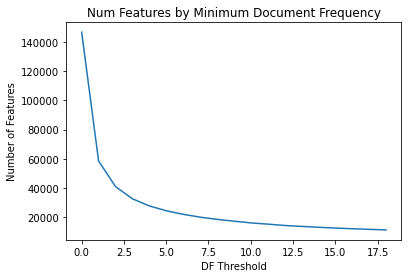

In [49]:
plt.plot(num_features)
plt.xlabel('DF Threshold')
plt.ylabel('Number of Features')
plt.title(f'Num Features by Minimum Document Frequency')
plt.show()

Elbow method? Try min_df of 5

In [56]:
combined = map(' '.join, zip(ctitles_stem, ctags_stem, cdesc_stem))
count_vectorizer = CountVectorizer(max_df=0.5, min_df=6)
combined_tf = count_vectorizer.fit_transform(combined)
combined_tf.shape

(30713, 24509)

In [57]:
feature_names = count_vectorizer.get_feature_names()

In [131]:
%%time
tmp = combined_tf.tocsc()
tmp = tmp.sum(axis=0)
num_cols = tmp.shape[1]
tmp = tmp.tolist()[0]

terms = {i: val for i, val in enumerate(tmp)}

del tmp, num_cols

CPU times: user 30.4 ms, sys: 3.96 ms, total: 34.3 ms
Wall time: 54.3 ms


In [135]:
combined_tf.shape

(30713, 24509)

In [140]:
combined_tf.getcol(0).count_nonzero()

10

In [142]:
def plotWf(dictionary, title, logscale=True):
    r"""Plot collection-wide word frequencies."""
    plt.plot(sorted(dictionary.values(), reverse=True))
    plt.xlabel('word')
    plt.ylabel('frequency')
    if logscale is True:
        plt.yscale('log')
        plt.ylabel('log(frequency)')
    plt.title(f'Corpus-wide word frequency distribution ({title})')
    plt.show()

def plotDf(mat, title, logscale=False):
    r"""Plot collection-wide document-word frequencies."""
    # document word frequency
    df = defaultdict(int)
    num_cols = mat.shape[1]
    for col in range(num_cols):
        df[col] += mat.getcol(col).count_nonzero()

    plt.plot(sorted(df.values(), reverse=True))
    plt.xlabel('word')
    plt.ylabel('frequency')
    if logscale is True:
        plt.yscale('log')
        plt.ylabel('log(frequency)')
    plt.title(f'Corpus-wide document-word frequency distribution ({title})')
    plt.show()

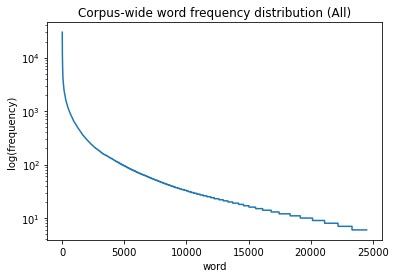

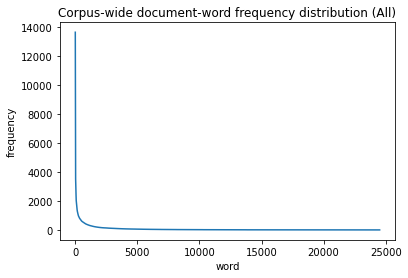

CPU times: user 3min 39s, sys: 704 ms, total: 3min 40s
Wall time: 4min 2s


In [145]:
%%time
plotWf(terms, 'All', logscale=True)
plotDf(combined_tf, 'All', logscale=False)

### Split into test / training

In [147]:
X_train, X_test, y_train, y_test = train_test_split(combined_tf,
                                                    dfd['category'], test_size=0.3, random_state=8)

### Scale by IDF and L2 normalize

In [148]:
transformer = TfidfTransformer(norm='l2', use_idf=True, sublinear_tf=True)

In [149]:
X_train_tr = transformer.fit_transform(X_train)
X_train_tr.shape

(21499, 24509)

In [150]:
X_test_tr = transformer.transform(X_test)
X_test_tr.shape

(9214, 24509)

### Training

In [63]:
def benchmark(clf, print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_tr, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_tr)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        print()

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [160]:
sgd = SGDClassifier(alpha=.0001, max_iter=100, penalty="l2")
benchmark(sgd)

________________________________________________________________________________
Training: 
SGDClassifier(max_iter=100)
train time: 1.234s
test time:  0.076s
accuracy:   0.825
dimensionality: 24509
density: 0.526019

confusion matrix:
[[  67    0    1    8    0    2    0    0    0    5    0    1    0    6
     0    0    0]
 [   1  583    1   82    2    9    4    0    9    5    0   25    2    0
     0    2    2]
 [   1    6  163   20    1    1    0    0    7    6    0    7    1    4
     0    1    0]
 [   4   32    9 2578   22   18   31    0   61   50    1   50    4   14
     4   20    2]
 [   0    7    2   98  305    1    5    0   14   17    0   18    3    9
     0    5    0]
 [   0    8    1   30    4  226    1    0    2    6    0    6    0    2
     0   10    0]
 [   0    1    0   24    1    1  510    0    3    4    0    9    0    4
     0    1    2]
 [   0    0    0    0    0    0    0    0    1    0    0    0    0    0
     0    0    0]
 [   1    6    0   48    2    1    0    0  68

('SGDClassifier', 0.8246147167354027, 1.2343895435333252, 0.07610273361206055)

In [161]:
predictions = sgd.predict(X_test_tr)
f1_score(y_test, predictions, average='macro')

0.7320234039225317

## Extra code

## Feature Importance

In [20]:
d = defaultdict(set) # channel_title: category_id
for row in df_usd.itertuples():
    d[row.channel_title].add(row.category_id)

dl = [len(val) for val in d.values()]
print(f'Number of unique youtube videos (US): {len(df_usd)}')
print(f'Number of unique channels: {len(d)}')
print(f'Max # of unique categories for a channel: {max(dl)}')
print(f'Average # of unique categories per channel: {sum(dl) / len(dl)}')

Number of unique youtube videos (US): 7302
Number of unique channels: 2207
Max # of unique categories for a channel: 7
Average # of unique categories per channel: 1.0693248753964657
